In [1]:
# Calculations
using WignerD: wignerdjmn
using SphericalHarmonics: sphericalharmonic
using Cubature: hcubature

# Unit testing
using Test

# Plots
using Plots
using LaTeXStrings

# Log and progress tracking
using Logging
using ProgressMeter

# DB and data processing
using SQLite
using DataFrames

# gr();  # Uses the GR backend for ploting
pythonplot();  # Uses the Matplotlib backend for ploting

# Functions definitions

In [2]:
# Rotated Spherical Harmonics and h functions

function y_rotated(; l::Integer, m::Integer)::Function
    """
    Calculate the spherical harmonic Y_{3, m} rotated by an angle alpha
    around the y-axis.

    Parameters
    ----------
    m : int
        The m quantum number.
    """
    
    function _inner(α::Float64, θ::Float64, ϕ::Float64)::ComplexF64
        result = 0.0 + 0.0im
        for m′ in -l:l
            result += sphericalharmonic(θ, ϕ; l=l, m=m′) * wignerdjmn(l, m′, m, α)
        end
        return result
    end
 
    return _inner
end


function h(α::Float64, θ::Float64, ϕ::Float64; s::Integer)::Float64
    """
    Calculate the h function.
    """
    @assert s in (+1, -1) "The spin projection must be +1 or -1."

    if s == +1
        m = 1
        clebsh_gordan = 2/7
    elseif s == -1
        m = 2
        clebsh_gordan = 5/7
    end

    return clebsh_gordan * abs(y_rotated(l=3, m=m)(α, θ, ϕ))^2 * (
        1/7 * abs(y_rotated(l=3, m=2)(α, θ, ϕ))^2 
        + 6/7 * abs(y_rotated(l=3, m=3)(α, θ, ϕ))^2
    )
end


function integrand_I(z::Float64, α::Float64, θ::Float64, ϕ::Float64; z₀::Float64=1e-2)::Float64
    """
    Integrand of the I integral.
    """
    @assert z₀ < 1 "z₀ must be less than 1."

    result = 3/(8 * π) * sin(θ) * cos(θ)^2 * sum(
        1 / (1 - h(α, θ, ϕ; s=s) * log(z₀) * z)
        for s in (-1, 1)
    )
    return real(result)
end


function I(z::Float64, α::Float64; z₀::Float64=1e-2)::Float64
    """
    Calculate the I integral.
    """
    return hcubature(
        x -> integrand_I(z, α, x[1], x[2]; z₀=z₀),
        [0.0, 0.0],
        [π, 2π],
        abstol=1e-6,
    )[1]
end


function A(z::Float64, α::Float64; z₀::Float64=1e-2)::Float64
    """
    Calculate the A factor.
    """
    return 1 - I(z, α; z₀=z₀) / I(z, 0.0; z₀=z₀)
end


A (generic function with 1 method)

# Tests

In [56]:
# Test the y_rotated function for l=3 and α = 0
@test isapprox(y_rotated(l=3, m=-1)(0.0, 0.0, 0.0), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(0.0, 0.0, π/2), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(0.0, 0.0, Float64(π)), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(0.0, π/2, 0.0), -1 * 1/8 * √(21 / π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(0.0, π/2, π/2), 1im * 1/8 * √(21 / π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(0.0, π/2, Float64(π)), 1/8 * √(21 / π) + 0.0im + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(0.0, π/4, 0.0), 3/16 * √(21 / 2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(0.0, π/4, π/2), -1im * 3/16 * √(21 / 2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(0.0, π/4, Float64(π)), -1 * 3/16 * √(21 / 2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(0.0, π/6, 0.0), 11/64 * √(21 / π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(0.0, π/6, π/2), -1im * 11/64 * √(21 / π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(0.0, π/6, Float64(π)), -1 * 11/64 * √(21 / π) + 0.0im; atol=1e-6)

@test isapprox(y_rotated(l=3, m=0)(0.0, 0.0, 0.0), √(7 / π) / 2 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(0.0, π/2, 0.0), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(0.0, π/4, 0.0), - 1/8 * √(7 / 2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(0.0, π/6, 0.0), 3/32 * √(21 / π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(0.0, 0.0, π/2), √(7 / π) / 2 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(0.0, π/2, π/2), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(0.0, π/4, π/2), - 1/8 * √(7 / 2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(0.0, π/6, π/2), 3/32 * √(21 / π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(0.0, 0.0, Float64(π)), √(7 / π) / 2 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(0.0, π/2, Float64(π)), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(0.0, π/4, Float64(π)), - 1/8 * √(7 / 2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(0.0, π/6, Float64(π)), 3/32 * √(21 / π); atol=1e-6)

@test isapprox(y_rotated(l=3, m=1)(0.0, 0.0, 0.0), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(0.0, π/2, 0.0), √(21 / π) / 8 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(0.0, π/4, 0.0), - 3/16 * √(21 / 2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(0.0, π/6, 0.0), - 11/64 * √(21 / π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(0.0, 0.0, π/2), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(0.0, π/2, π/2), 0.0 + 1im / 8 * √(21 / π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(0.0, π/4, π/2), 0.0 + -3im / 16 * √(21 / 2π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(0.0, π/6, π/2), 0.0 + -11im / 64 * √(21 / π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(0.0, 0.0, Float64(π)), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(0.0, π/2, Float64(π)), -√(21 / π) / 8 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(0.0, π/4, Float64(π)), 3/16 * √(21 / 2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(0.0, π/6, Float64(π)), 11/64 * √(21 / π) + 0.0im; atol=1e-6)

@test isapprox(y_rotated(l=3, m=2)(0.0, 0.0, 0.0), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(0.0, 0.0, π/2), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(0.0, 0.0, Float64(π)), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(0.0, π/2, 0.0), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(0.0, π/2, π/2), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(0.0, π/2, Float64(π)), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(0.0, π/4, 0.0), 1/16 * √(105 / π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(0.0, π/4, π/2), -1/16 * √(105 / π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(0.0, π/4, Float64(π)), 1/16 * √(105 / π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(0.0, π/6, 0.0), 3/32 * √(35 / 2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(0.0, π/6, π/2), -3/32 * √(35 / 2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(0.0, π/6, Float64(π)), 3/32 * √(35 / 2π) + 0.0im; atol=1e-6)

@test isapprox(y_rotated(l=3, m=3)(0.0, 0.0, 0.0), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(0.0, 0.0, π/2), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(0.0, 0.0, Float64(π)), 0.0 + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(0.0, π/2, 0.0), -1/8 * √(35/π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(0.0, π/2, π/2), 1im/8 * √(35/π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(0.0, π/2, Float64(π)), 1/8 * √(35/π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(0.0, π/4, 0.0), -1/16 * √(35/2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(0.0, π/4, π/2), 1im/16 * √(35/2π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(0.0, π/4, Float64(π)), 1/16 * √(35/2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(0.0, π/6, 0.0), -1/64 * √(35/π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(0.0, π/6, π/2), 1im/64 * √(35/π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(0.0, π/6, Float64(π)), 1/64 * √(35/π) + 0.0im; atol=1e-6) 


# Test the y_rotated function for l=3 and α = π/2
@test isapprox(y_rotated(l=3, m=-3)(π/2, 0.0, 0.0), -1/8 * √(35/π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=-3)(π/2, π/2, 0.0), 0; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-3)(π/2, π/4, 0.0), -1/16 * √(35/2π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=-3)(π/2, π/6, 0.0), -3/64 * √(105/π); atol=1e-6)

@test isapprox(y_rotated(l=3, m=-2)(π/2, 0.0, 0.0), 0; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-2)(π/2, π/2, 0.0), 0; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-2)(π/2, π/4, 0.0), 1/16 * √(105/π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=-2)(π/2, π/6, 0.0), 3/32 * √(105/2π); atol=1e-6)

@test isapprox(y_rotated(l=3, m=-1)(π/2, 0.0, 0.0), 1/8 * √(21/π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(π/2, π/2, 0.0), 0; atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(π/2, π/4, 0.0), -3/16 * √(21/2π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=-1)(π/2, π/6, 0.0), -3/64 * √(7/π); atol=1e-6)

@test isapprox(y_rotated(l=3, m=0)(π/2, 0.0, 0.0), 0; atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(π/2, π/2, 0.0), 1/2 * √(7 / π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(π/2, π/4, 0.0), - 1/8 * √(7 / 2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=0)(π/2, π/6, 0.0), -7/32 * √(7 / π); atol=1e-6)

@test isapprox(y_rotated(l=3, m=1)(π/2, 0.0, 0.0), -1/8 * √(21 / π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(π/2, π/2, 0.0), 0; atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(π/2, π/4, 0.0), 3/16 * √(21 / 2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=1)(π/2, π/6, 0.0), 3/64 * √(7 / π) + 0.0im; atol=1e-6)

@test isapprox(y_rotated(l=3, m=2)(π/2, 0.0, 0.0), 0; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(π/2, π/2, 0.0), 0; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(π/2, π/4, 0.0), 1/16 * √(105 / π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=2)(π/2, π/6, 0.0), 3/32 * √(105 / 2π) + 0.0im; atol=1e-6)

@test isapprox(y_rotated(l=3, m=3)(π/2, 0.0, 0.0), 1/8 * √(35/π); atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(π/2, π/2, 0.0), 0; atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(π/2, π/4, 0.0), 1/16 * √(35/2π) + 0.0im; atol=1e-6)
@test isapprox(y_rotated(l=3, m=3)(π/2, π/6, 0.0), 3/64 * √(105/π) + 0.0im; atol=1e-6)


Test Passed

In [82]:
# Tests for the h function
@test isapprox(h(0.0, 0.0, 0.0; s=-1), 0; atol=1e-6)
@test isapprox(h(0.0, π/2, 0.0; s=-1), 0; atol=1e-6)
@test isapprox(h(0.0, π/4, 0.0; s=-1), 1125/(32768 * π^2); atol=1e-6)
@test isapprox(h(0.0, π/6, 0.0; s=-1), 3375/(1048576 * π^2); atol=1e-6)

@test isapprox(h(0.0, 0.0, 0.0; s=+1), 0; atol=1e-6)
@test isapprox(h(0.0, π/2, 0.0; s=+1), 45/(1024 * π^2) ; atol=1e-6)
@test isapprox(h(0.0, π/4, 0.0; s=+1), 405/(32768 * π^2); atol=1e-6)
@test isapprox(h(0.0, π/6, 0.0; s=+1), 5445/(1048576 * π^2); atol=1e-6)

@test isapprox(h(0.0, 0.0, π/4; s=-1), 0; atol=1e-6)
@test isapprox(h(0.0, π/2, π/4; s=-1), 0; atol=1e-6)
@test isapprox(h(0.0, π/4, π/4; s=-1), 1125/(32768 * π^2); atol=1e-6)
@test isapprox(h(0.0, π/6, π/4; s=-1), 3375/(1048576 * π^2); atol=1e-6)

@test isapprox(h(0.0, 0.0, π/4; s=+1), 0; atol=1e-6)
@test isapprox(h(0.0, π/2, π/4; s=+1), 45/(1024 * π^2) ; atol=1e-6)
@test isapprox(h(0.0, π/4, π/4; s=+1), 405/(32768 * π^2); atol=1e-6)
@test isapprox(h(0.0, π/6, π/4; s=+1), 5445/(1048576 * π^2); atol=1e-6)

@test isapprox(h(π/2, 0.0, 0.0; s=-1), 0; atol=1e-6)
@test isapprox(h(π/2, π/2, 0.0; s=-1), 0; atol=1e-6)
@test isapprox(h(π/2, π/4, 0.0; s=-1), 1125/(32768 * π^2); atol=1e-6)
@test isapprox(h(π/2, π/6, 0.0; s=-1), 91125/(1048576 * π^2); atol=1e-6)

@test isapprox(h(π/2, 0.0, 0.0; s=+1), 45/(1024 * π^2); atol=1e-6)
@test isapprox(h(π/2, π/2, 0.0; s=+1), 0; atol=1e-6)
@test isapprox(h(π/2, π/4, 0.0; s=+1), 405/(32768 * π^2); atol=1e-6)
@test isapprox(h(π/2, π/6, 0.0; s=+1), 1215/(1048576 * π^2); atol=1e-6)

@test isapprox(h(π/2, 0.0, π/4; s=-1), 0; atol=1e-6)
@test isapprox(h(π/2, π/2, π/4; s=-1), 1125/(32768 * π^2); atol=1e-6)
@test isapprox(h(π/2, π/4, π/4; s=-1), 91125/(1048576 * π^2); atol=1e-6)
@test isapprox(h(π/2, π/6, π/4; s=-1), 2701125/(33554432 * π^2); atol=1e-6)

@test isapprox(h(π/2, 0.0, π/4; s=+1), 45/(1024 * π^2); atol=1e-6)
@test isapprox(h(π/2, π/2, π/4; s=+1), 405/(32768 * π^2); atol=1e-6)
@test isapprox(h(π/2, π/4, π/4; s=+1), 1215/(1048576 * π^2); atol=1e-6)
@test isapprox(h(π/2, π/6, π/4; s=+1), 138915/(33554432 * π^2); atol=1e-6)


Test Passed

In [86]:
# Test the integrand_I function (ϕ=0, z₀=1e-2)
# α = 0, z = 0
@test isapprox(integrand_I(0.0, 0.0, 0.0, 0.0; z₀=1e-2), 0.0; atol=1e-6)
@test isapprox(integrand_I(0.0, 0.0, π/2, 0.0; z₀=1e-2), 0.0; atol=1e-6)
@test isapprox(integrand_I(0.0, 0.0, π/1, 0.0; z₀=1e-2), 0.0; atol=1e-6)
@test isapprox(integrand_I(0.0, 0.0, π/4, 0.0; z₀=1e-2), 2 * 3/(8 * π) * (1 / √2)^3; atol=1e-6)

# α = π/2, z = 0
@test isapprox(integrand_I(0.0, π/2, 0.0, 0.0; z₀=1e-2), 0.0; atol=1e-6)
@test isapprox(integrand_I(0.0, π/2, π/2, 0.0; z₀=1e-2), 0.0; atol=1e-6)
@test isapprox(integrand_I(0.0, π/2, π/1, 0.0; z₀=1e-2), 0.0; atol=1e-6)
@test isapprox(integrand_I(0.0, π/2, π/4, 0.0; z₀=1e-2), 2 * 3/(8 * π) * (1 / √2)^3; atol=1e-6)

# α = 0, z variable
@test isapprox(integrand_I(0.1, 0.0, π/4, 0.0; z₀=1e-2), 0.0843128; atol=1e-6)
@test isapprox(integrand_I(0.2, 0.0, π/4, 0.0; z₀=1e-2), 0.0842213; atol=1e-6)
@test isapprox(integrand_I(0.3, 0.0, π/4, 0.0; z₀=1e-2), 0.0841299; atol=1e-6)
@test isapprox(integrand_I(0.4, 0.0, π/4, 0.0; z₀=1e-2), 0.0840388; atol=1e-6)
@test isapprox(integrand_I(1.0, 0.0, π/4, 0.0; z₀=1e-2), 0.0834973; atol=1e-6)
@test isapprox(integrand_I(2.0, 0.0, π/4, 0.0; z₀=1e-2), 0.0826133; atol=1e-6)
@test isapprox(integrand_I(3.0, 0.0, π/4, 0.0; z₀=1e-2), 0.0817518; atol=1e-6)
@test isapprox(integrand_I(4.0, 0.0, π/4, 0.0; z₀=1e-2), 0.0809117; atol=1e-6)
@test isapprox(integrand_I(10.0, 0.0, π/4, 0.0; z₀=1e-2), 0.0762764; atol=1e-6)
@test isapprox(integrand_I(100.0, 0.0, π/4, 0.0; z₀=1e-2), 0.0429857; atol=1e-6)

# α = π/2, z variable
@test isapprox(integrand_I(0.1, π/2, π/4, 0.0; z₀=1e-2), 0.0843128; atol=1e-6)
@test isapprox(integrand_I(0.2, π/2, π/4, 0.0; z₀=1e-2), 0.0842213; atol=1e-6)
@test isapprox(integrand_I(0.3, π/2, π/4, 0.0; z₀=1e-2), 0.0841299; atol=1e-6)
@test isapprox(integrand_I(0.4, π/2, π/4, 0.0; z₀=1e-2), 0.0840388; atol=1e-6)
@test isapprox(integrand_I(1.0, π/2, π/4, 0.0; z₀=1e-2), 0.0834973; atol=1e-6)
@test isapprox(integrand_I(2.0, π/2, π/4, 0.0; z₀=1e-2), 0.0826133; atol=1e-6)
@test isapprox(integrand_I(3.0, π/2, π/4, 0.0; z₀=1e-2), 0.0817518; atol=1e-6)
@test isapprox(integrand_I(4.0, π/2, π/4, 0.0; z₀=1e-2), 0.0809117; atol=1e-6)
@test isapprox(integrand_I(10.0, π/2, π/4, 0.0; z₀=1e-2), 0.0762764; atol=1e-6)
@test isapprox(integrand_I(100.0, π/2, π/4, 0.0; z₀=1e-2), 0.0429857; atol=1e-6)


# # Test the integral I
@test isapprox(I(0.0, 0.0; z₀=1e-2), 1; atol=1e-6)
@test isapprox(I(0.0, π/3; z₀=1e-2), 1; atol=1e-6)
@test isapprox(I(0.0, π/2; z₀=1e-2), 1; atol=1e-6)


# # Test the Anisotropia function
@test isapprox(A(0.0, 0.0; z₀=1e-2), 0; atol=1e-6)
@test isapprox(A(0.0, π/3; z₀=1e-2), 0; atol=1e-6)
@test isapprox(A(0.0, π/2; z₀=1e-2), 0; atol=1e-6)


Test Passed

# Prepare DB tables to store calculated data

In [3]:
db = SQLite.DB("aniso__j_5_2__l_3.sqlite")


# Create the tables
SQLite.execute(db, """
    CREATE TABLE IF NOT EXISTS integral_I (
        z REAL NOT NULL,
        α REAL NOT NULL,
        z₀ REAL NOT NULL,
        I REAL NOT NULL,
        PRIMARY KEY (z, α, z₀)
    );
""")

SQLite.execute(db, """
    CREATE TABLE IF NOT EXISTS anisotropy (
        z REAL NOT NULL,
        α REAL NOT NULL,
        z₀ REAL NOT NULL,
        A REAL NOT NULL,
        PRIMARY KEY (z, α, z₀)
    );
""")

101

In [4]:
# Helper functions

"""   
High order function to cache the results of the `func`
function in the `db` database.

It returns a new function that:
- When the result is already in the database, it returns the value from the
  database.
- When the result is not in the database, it calculates the value using the
  `func` function and stores it in the database.
"""
function with_db_cache(db::SQLite.DB; table_name::String, func::Function)
	col_name = nameof(func)

	return function(z, α; z₀=1e-2)
		query = "SELECT $col_name FROM $table_name WHERE z = ? AND α = ? AND z₀ = ?;"
		result = DBInterface.execute(db, query, (z, α, z₀)) |> DataFrame

		if !isempty(result)
			return result[1, Symbol(col_name)]
		else
			val = func(z, α, z₀=z₀)

			insert_query = "INSERT INTO $table_name (z, α, z₀, $col_name) VALUES (?, ?, ?, ?);"
			DBInterface.execute(db, insert_query, (z, α, z₀, val))

			return val
		end
	end
end


function call_with_progress(func::Function, range; desc::Union{String, Nothing}=nothing)
    desc = desc == nothing ? "" : desc
	@showprogress desc for x in range
        func(x)
    end
end

call_with_progress (generic function with 1 method)

In [5]:
# Create the cached functions. The first time they are called, they will calculate the
# value and store it in the database. The next time they are called with the same
# arguments, they will return the value from the database.
I′ = with_db_cache(db, table_name="integral_I", func=I)
A′ = with_db_cache(db, table_name="anisotropy", func=A)

#12 (generic function with 1 method)

# Cálculos

In [6]:
z_range = 0:0.1:100
α_range = 0:0.001:π/2

0.0:0.001:1.57

In [78]:
"""
Calculating I(z, α) and A(z, α) for z in z_range and α in α_range

When z is varying, α is taken to be 0, π/6, π/3, π/2
When α is varying, z is taken to be 1, 10, 100
"""

call_with_progress(z -> I′(z, 0.0), z_range; desc="Calculating I(z, 0.0)")
call_with_progress(z -> I′(z, π/6), z_range; desc="Calculating I(z, π/6)")
call_with_progress(z -> I′(z, π/3), z_range; desc="Calculating I(z, π/3)")
call_with_progress(z -> I′(z, π/2), z_range; desc="Calculating I(z, π/2)")

call_with_progress(α -> I′(1.0, α), α_range; desc="Calculating I(1.0, α)")
call_with_progress(α -> I′(10.0, α), α_range; desc="Calculating I(10.0, α)")
call_with_progress(α -> I′(100.0, α), α_range; desc="Calculating I(100.0, α)")

call_with_progress(z -> A′(z, 0.0), z_range; desc="Calculating A(z, 0.0)")
call_with_progress(z -> A′(z, π/6), z_range; desc="Calculating A(z, π/6)")
call_with_progress(z -> A′(z, π/3), z_range; desc="Calculating A(z, π/3)")
call_with_progress(z -> A′(z, π/2), z_range; desc="Calculating A(z, π/2)")

call_with_progress(α -> A′(1.0, α), α_range; desc="Calculating A(1.0, α)")
call_with_progress(α -> A′(10.0, α), α_range; desc="Calculating A(10.0, α)")
call_with_progress(α -> A′(100.0, α), α_range; desc="Calculating A(100.0, α)")

Calculating I(z, 0.0) 100%|██████████████████████████████| Time: 0:01:53
Calculating I(z, π/6) 100%|██████████████████████████████| Time: 0:07:07
Calculating I(z, π/3) 100%|██████████████████████████████| Time: 0:13:49
Calculating I(z, π/2) 100%|██████████████████████████████| Time: 0:13:40
Calculating I(1.0, α) 100%|██████████████████████████████| Time: 0:05:13
Calculating I(10.0, α) 100%|█████████████████████████████| Time: 0:09:40
Calculating I(100.0, α) 100%|████████████████████████████| Time: 0:22:22
Calculating A(z, 0.0) 100%|██████████████████████████████| Time: 0:02:01
Calculating A(z, π/6) 100%|██████████████████████████████| Time: 0:10:36
Calculating A(z, π/3) 100%|██████████████████████████████| Time: 0:14:05
Calculating A(z, π/2) 100%|██████████████████████████████| Time: 0:13:57
Calculating A(1.0, α) 100%|██████████████████████████████| Time: 0:05:28
Calculating A(10.0, α) 100%|█████████████████████████████| Time: 0:10:05
Calculating A(100.0, α) 100%|██████████████████████

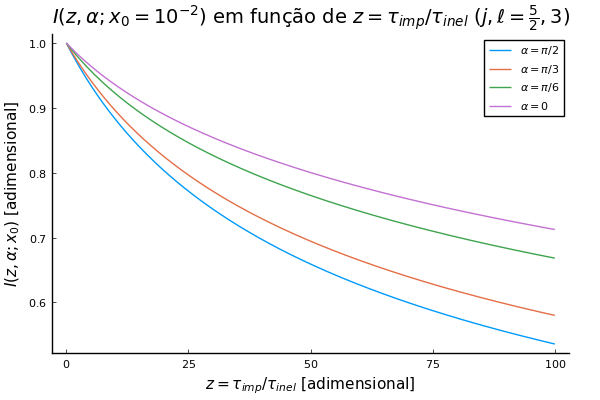

In [7]:
"""
Plot de I(z, α; z₀) em função de z
α = 0, π/6, π/3, π/2
z₀ = 1e-2
"""

Ix = [I′(z, π/2) for z in z_range]
I1 = [I′(z, π/3) for z in z_range]
I2 = [I′(z, π/6) for z in z_range]
Iz = [I′(z, 0.0) for z in z_range]

plot(
    z_range,
    [Ix, I1, I2, Iz],
    label=[L"$\alpha=\pi/2$" L"$\alpha=\pi/3$" L"$\alpha=\pi/6$" L"$\alpha=0$"],
    xlabel=L"$z=\tau_{imp}/\tau_{inel}$ [adimensional]",
    ylabel=L"$I(z, \alpha; x_0)$ [adimensional]",
    title=L"$I(z, \alpha; x_0=10^{-2})$ em função de $z=\tau_{imp}/\tau_{inel}$ $(j,\ell=\frac{5}{2},3)$",
	grid=false,
)

In [10]:
savefig("./j__5_2_eps/I_z__5_2.eps")

"/home/alex/Mestrado/Numerics/aniso/j__5_2_eps/I_z__5_2.eps"

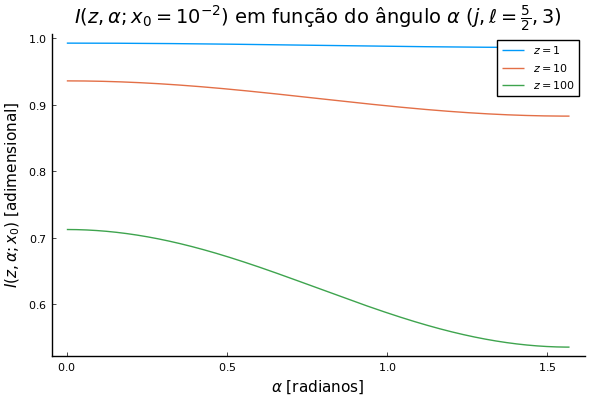

In [11]:
"""
Plot de I(z, α; z₀) em função de z
α = 0, π/6, π/3, π/2
z₀ = 1e-2
"""

I_1 = [I′(1.0, α) for α in α_range]
I_10 = [I′(10.0, α) for α in α_range]
I_100 = [I′(100.0, α) for α in α_range]

plot(
    α_range,
    [I_1, I_10, I_100],
    label=[L"$z=1$" L"$z=10$" L"$z=100$"],
    xlabel=L"$\alpha$ [radianos]",
    ylabel=L"$I(z, \alpha; x_0)$ [adimensional]",
    title=L"$I(z, \alpha; x_0=10^{-2})$ em função do ângulo $\alpha$ $(j,\ell=\frac{5}{2},3)$",
	grid=false,
)

In [12]:
savefig("./j__5_2_eps/I_alphas__5_2.eps")

"/home/alex/Mestrado/Numerics/aniso/j__5_2_eps/I_alphas__5_2.eps"

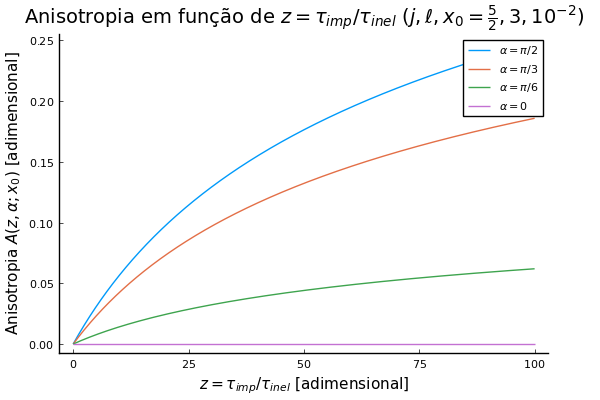

In [13]:
"""
Plot de A(z, α; z₀) em função de z
alpha = 0, π/6, π/3, π/2
x0 = 1e-2
"""

Ax = [A′(z, π/2) for z in z_range]
A1 = [A′(z, π/3) for z in z_range]
A2 = [A′(z, π/6) for z in z_range]
Az = [A′(z, 0.0) for z in z_range]

plot(
    z_range,
    [Ax, A1, A2, Az],
    label=[L"$\alpha=\pi/2$" L"$\alpha=\pi/3$" L"$\alpha=\pi/6$" L"$\alpha=0$"],
    xlabel=L"$z = \tau_{imp}/\tau_{inel}$ [adimensional]",
    ylabel=L"Anisotropia $A(z, \alpha; x_0)$ [adimensional]",
    title=L"Anisotropia em função de $z=\tau_{imp}/\tau_{inel}$ $(j,\ell,x_0 = \frac{5}{2},3, 10^{-2})$",
	grid=false,
)

In [14]:
savefig("./j__5_2_eps/A_z__5_2.eps")

"/home/alex/Mestrado/Numerics/aniso/j__5_2_eps/A_z__5_2.eps"

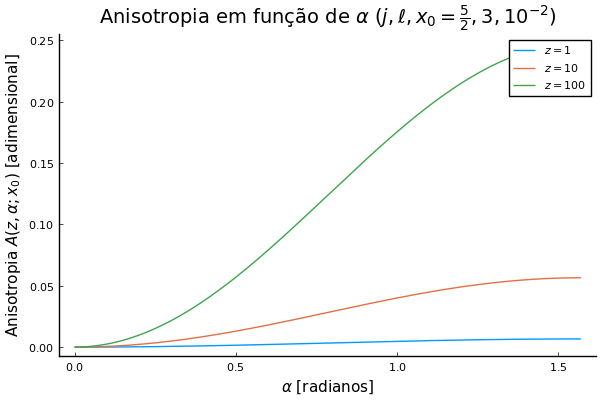

In [15]:
"""
Plot de A(z, α; z₀) em função de α
z = 100, 1000
z₀ = 1e-2
"""

A1 = [A′(1.0, α) for α in α_range]
A10 = [A′(10.0, α) for α in α_range]
A100 = [A′(100.0, α) for α in α_range]

plot(
    α_range,
    [A1, A10, A100],
    label=[L"$z=1$" L"$z=10$" L"$z=100$"],
    xlabel=L"$\alpha$ [radianos]",
    ylabel=L"Anisotropia $A(z, \alpha; x_0)$ [adimensional]",
    title=L"Anisotropia em função de $\alpha$ $(j,\ell,x_0 = \frac{5}{2}, 3, 10^{-2})$",
	grid=false,
)

In [16]:
savefig("./j__5_2_eps/A_alphas__5_2.eps")

"/home/alex/Mestrado/Numerics/aniso/j__5_2_eps/A_alphas__5_2.eps"